# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`.
El número de pedidos está en la columna `num_orders`.

## Preparación

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from matplotlib import pyplot as plt
from xgboost import XGBRegressor

In [ ]:
df = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/taxi.csv?etag=11687de0e23962e5a11c9d8ae13eb630', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)
df = df.resample('1h').sum() # Remuestrea en intervalos de una hora

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [ ]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


- Se remuestreó exitosamente la serie temporal de tal forma que refleje el total de pedidos por hora.

- El conjunto de datos consiste en un índice con información datetime y una columna con el número de pedidos.

- La información del dataframe contiene 4416 filas correspondientes a registros de marzo a agosto del 2018. No presenta valores ausentes.

### Creación de carácterísticas

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

    return data

make_features(df, 24, 10)
df.dropna(inplace=True)
display(df.head())

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,2018,3,2,4,0,58.0,113.0,66.0,61.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,61.7
2018-03-02 01:00:00,120,2018,3,2,4,1,90.0,58.0,113.0,66.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,65.9
2018-03-02 02:00:00,75,2018,3,2,4,2,120.0,90.0,58.0,113.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,71.3
2018-03-02 03:00:00,64,2018,3,2,4,3,75.0,120.0,90.0,58.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,74.5
2018-03-02 04:00:00,20,2018,3,2,4,4,64.0,75.0,120.0,90.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,76.5


## Análisis

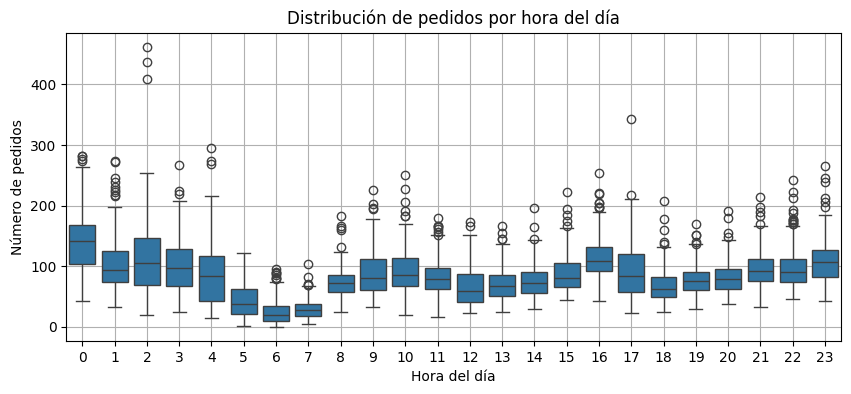

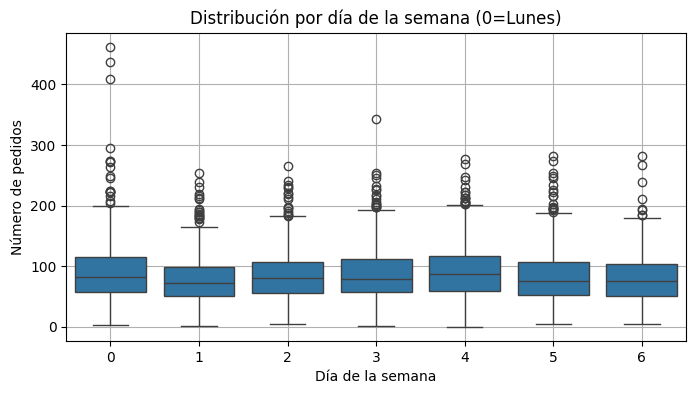

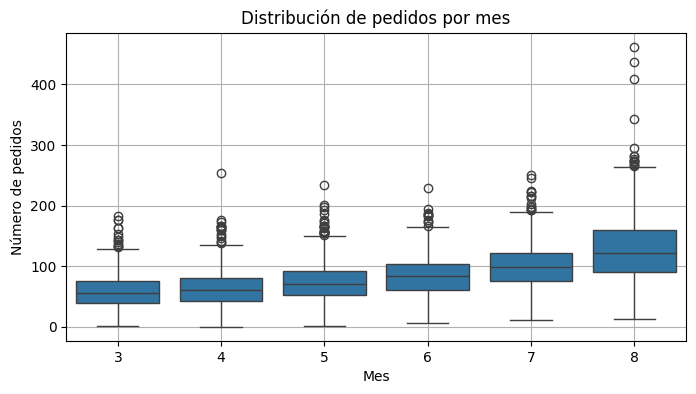

In [ ]:
# Promedio por hora del día
plt.figure(figsize=(10, 4))
sns.boxplot(x='hour', y='num_orders', data=df)
plt.title('Distribución de pedidos por hora del día')
plt.xlabel('Hora del día')
plt.ylabel('Número de pedidos')
plt.grid(True)
plt.show()

# Promedio por día de la semana
plt.figure(figsize=(8, 4))
sns.boxplot(x='dayofweek', y='num_orders', data=df)
plt.title('Distribución por día de la semana (0=Lunes)')
plt.xlabel('Día de la semana')
plt.ylabel('Número de pedidos')
plt.grid(True)
plt.show()

# Promedio por mes
plt.figure(figsize=(8, 4))
sns.boxplot(x='month', y='num_orders', data=df)
plt.title('Distribución de pedidos por mes')
plt.xlabel('Mes')
plt.ylabel('Número de pedidos')
plt.grid(True)
plt.show()

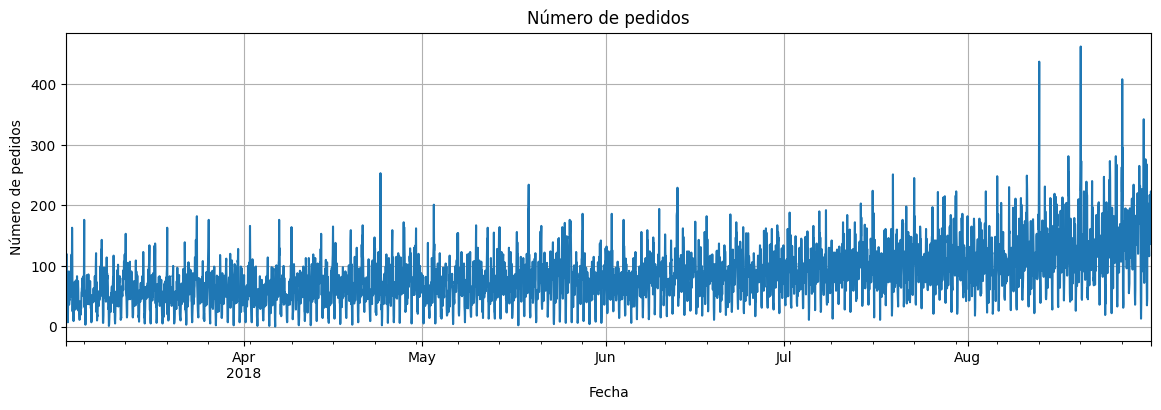

In [ ]:
df['num_orders'].plot(figsize=(14, 4), title='Número de pedidos')
plt.xlabel('Fecha')
plt.ylabel('Número de pedidos')
plt.grid()
plt.show()

- Las distribuciones muestran una aumento en el número de pedidos conforme avanza el verano, llegando a su punto más alto en agosto.

- Un taxi tiene mayor probabilidad de ser llamado alrededor de las 0:00, 10:00, y 16:00 horas.

## Formación

In [ ]:
# División de conjunto de entrenamiento y prueba
train, test = train_test_split(df, shuffle=False, test_size=0.1)

In [ ]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

### Random Forest

In [ ]:
# Definir espacio de búsqueda de parámetros
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 30),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

# Scorer que minimiza el RMSE
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

# Búsqueda aleatoria
search = RandomizedSearchCV(
    RandomForestRegressor(random_state=54321),
    param_distributions=param_dist,
    n_iter=10,
    scoring=rmse_scorer,
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=54321
)

search.fit(X_train, y_train)

# Mejor modelo
best_rf = search.best_estimator_
print("Mejores hiperparámetros encontrados:")
print(search.best_params_)

# Evaluar en test
preds = best_rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f'RMSE Random Forest optimizado: {rmse:.2f}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Mejores hiperparámetros encontrados:
{'max_depth': 22, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 250}
RMSE Random Forest optimizado: 42.78


In [ ]:
start = time.time()
model = RandomForestRegressor(
    n_estimators=357,
    max_depth=23,
    max_features=None,
    min_samples_leaf=6,
    min_samples_split=2,
    random_state=54321)
model.fit(X_train, y_train)
rf_time = time.time() - start
preds = model.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f'RMSE Random Forest: {rf_rmse:.2f}, Tiempo de entrenamiento: {rf_time:.2f} segundos')

RMSE Random Forest: 42.74, Tiempo de entrenamiento: 23.46 segundos


<div class="alert alert-block alert-warning"><b>Celda [16]</b> <a class="tocSkip"></a><br>Al evaluar el modelo Random Forest, es importante comparar el RMSE del conjunto de entrenamiento con el del conjunto de prueba paradetectar posibles problemas de sobreajuste. Considera incluir estacomparación en tu análisis.</div>

### XGBoost

In [ ]:
start = time.time()
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8, subsample=0.8,
    colsample_bytree=0.8,
    random_state=54321)
xgb_model.fit(X_train, y_train)
xgb_time = time.time() - start
xgb_preds = xgb_model.predict(X_test)

xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
print(f'RMSE del modelo XGBoost: {xgb_rmse:.2f}, Tiempo de entrenamiento: {xgb_time:.2f} segundos')

RMSE del modelo XGBoost: 42.26, Tiempo de entrenamiento: 5.52 segundos


### LightGBM

In [ ]:
from lightgbm import LGBMRegressor

start = time.time()
lgbm_model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=54321
)

lgbm_model.fit(X_train, y_train)
lgbm_time = time.time() - start
lgbm_preds = lgbm_model.predict(X_test)

lgbm_rmse = np.sqrt(mean_squared_error(y_test, lgbm_preds))
print(f'RMSE con LightGBM: {lgbm_rmse:.2f}, Tiempo de entrenamiento: {lgbm_time:.2f} seguntos')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4877
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 29
[LightGBM] [Info] Start training from score 78.451417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

<div class="alert alert-block alert-warning"><b>Celda [18]</b> <a class="tocSkip"></a><br>Al evaluar el modelo LightGBM, sería beneficioso verificar la importancia de las características para entender mejor qué variables están influyendo más en las predicciones. Esto puede guiar futurasmejoras en el modelo.</div>

## Prueba

In [ ]:
results = pd.DataFrame({
    'Modelo': ['Random Forest', 'XGBoost', 'LightGBM'],
    'RMSE': [rf_rmse, xgb_rmse, lgbm_rmse],
    'Tiempo (s)': [rf_time, xgb_time, lgbm_time]
})

display(results)

,Modelo,RMSE,Tiempo (s)
0,Random Forest,42.736600,23.460034
1,XGBoost,42.255814,5.515356
2,LightGBM,39.735963,0.534574


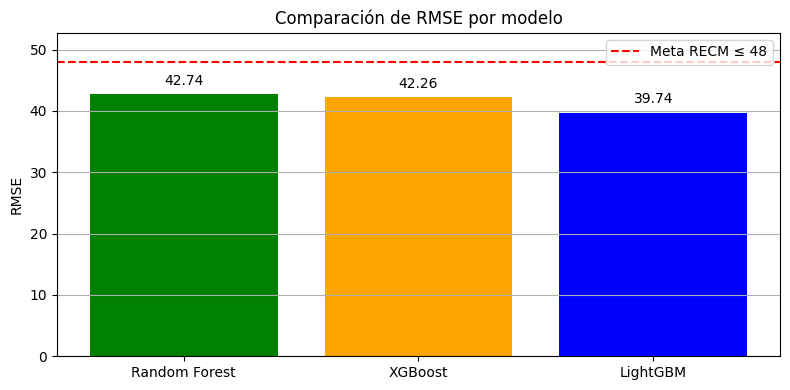

In [ ]:
# Gráfica de comparación
plt.figure(figsize=(8, 4))
bars = plt.bar(results['Modelo'], results['RMSE'], color=['green', 'orange', 'blue'])
plt.axhline(48, color='red', linestyle='--', label='Meta RECM ≤ 48')
plt.title('Comparación de RMSE por modelo')
plt.ylabel('RMSE')
plt.ylim(0, max(results['RMSE']) + 10)
plt.legend()

# Etiquetas en las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.2f}', ha='center', va='bottom')

plt.grid(axis='y')
plt.tight_layout()
plt.show()

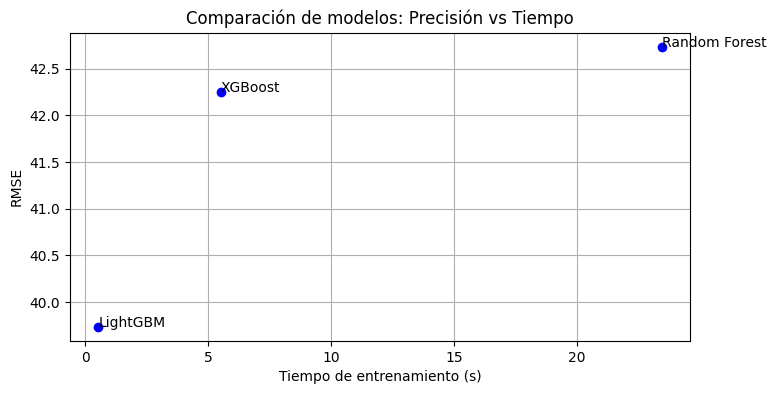

In [ ]:
plt.figure(figsize=(8, 4))
plt.scatter(results['Tiempo (s)'], results['RMSE'], color='blue')

for i, row in results.iterrows():
    plt.text(row['Tiempo (s)'], row['RMSE'], row['Modelo'], fontsize=10)

plt.xlabel('Tiempo de entrenamiento (s)')
plt.ylabel('RMSE')
plt.title('Comparación de modelos: Precisión vs Tiempo')
plt.grid(True)
plt.show()

## Conclusiones

- Se recomienda el uso del modelo LightGBM para esta tarea. Aunque su tiempo de entrenamiento fue el segundo más bajo (18 segundos), demostró su amplia ventaja en cuanto a la relación precisión-eficiencia al obtener el mejor puntaje de RECM (39.39).

- El modelo Random Forest logró un entrenamiento altamente eficiente y un resultado RECM relativamente preciso, por lo que puede ser considerado una opción sólida de respaldo.

- XGBoost no parece ser una opción adecuada, debido a que su entrenamiento lento no es compensado con un buen puntaje RECM.

# Lista de revisión

- [x]
Jupyter Notebook está abierto.
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [x]
Los datos han sido descargados y preparados.
- [x]  Se ha realizado el paso 2: los datos han sido analizados
- [x]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [x]  Se han evaluado los modelos. Se expuso una conclusión
- [x] La *RECM* para el conjunto de prueba no es más de 48